<a href="https://www.kaggle.com/code/rahulchauhan016/bug-intelligence-system-using-bert?scriptVersionId=297113717" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# AI Bug Intelligence System


## BERT Fine-Tuning on 50K Bug Reports

> * This notebook builds an AI system to automatically classify bug severity using BERT.

> * The goal is to improve bug triaging and software maintenance workflows.


## Install Dependencies

In [1]:
!pip install -q transformers datasets accelerate scikit-learn


## Import Required Libraries


In [2]:
import os
os.environ["DISABLE_TQDM"] = "1"

import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

from datasets import Dataset

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)



2026-02-11 07:59:29.045308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770796769.226285      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770796769.277165      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770796769.706305      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770796769.706344      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770796769.706347      55 computation_placer.cc:177] computation placer alr

 ## Load  Dataset


In [3]:
DATA_PATH = "/kaggle/input/50k-bug-dataset/bug_dataset_50k.csv"
df = pd.read_csv(DATA_PATH)

print(df.shape)
df.head()


(50000, 14)


,bug_id,title,description,error_code,bug_category,bug_domain,tech_stack,severity,environment,developer_role,root_cause,suggested_fix,explanation,created_at
0,BUG_000001,API Bug detected in system,This issue relates to a api bug occurring in t...,403.0,API Bug,Mobile,Spring Boot,High,Development,Full-Stack Developer,Misconfiguration or logic issue related to api...,Review and fix the api bug according to best p...,This bug requires a full-stack developer due t...,2025-04-07
1,BUG_000002,Memory Leak detected in system,This issue relates to a memory leak occurring ...,500.0,Memory Leak,Data,GCP,Medium,Production,Backend Developer,Misconfiguration or logic issue related to mem...,Review and fix the memory leak according to be...,This bug requires a backend developer due to i...,2025-07-04
2,BUG_000003,Cloud Configuration Bug detected in system,This issue relates to a cloud configuration bu...,404.0,Cloud Configuration Bug,DevOps,Django,Medium,Production,Mobile Developer,Misconfiguration or logic issue related to clo...,Review and fix the cloud configuration bug acc...,This bug requires a mobile developer due to it...,2025-05-02
3,BUG_000004,Authentication Bug detected in system,This issue relates to a authentication bug occ...,404.0,Authentication Bug,Backend Systems,Flask,Medium,Production,Mobile Developer,Misconfiguration or logic issue related to aut...,Review and fix the authentication bug accordin...,This bug requires a mobile developer due to it...,2025-07-03
4,BUG_000005,Logging Bug detected in system,This issue relates to a logging bug occurring ...,503.0,Logging Bug,Mobile,Flask,High,Staging,Backend Developer,Misconfiguration or logic issue related to log...,Review and fix the logging bug according to be...,This bug requires a backend developer due to i...,2025-09-09


## Dataset Structure Overview


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bug_id          50000 non-null  object 
 1   title           50000 non-null  object 
 2   description     50000 non-null  object 
 3   error_code      43812 non-null  float64
 4   bug_category    50000 non-null  object 
 5   bug_domain      50000 non-null  object 
 6   tech_stack      50000 non-null  object 
 7   severity        50000 non-null  object 
 8   environment     50000 non-null  object 
 9   developer_role  50000 non-null  object 
 10  root_cause      50000 non-null  object 
 11  suggested_fix   50000 non-null  object 
 12  explanation     50000 non-null  object 
 13  created_at      50000 non-null  object 
dtypes: float64(1), object(13)
memory usage: 5.3+ MB


## Bug Severity Distribution


<Axes: xlabel='severity'>

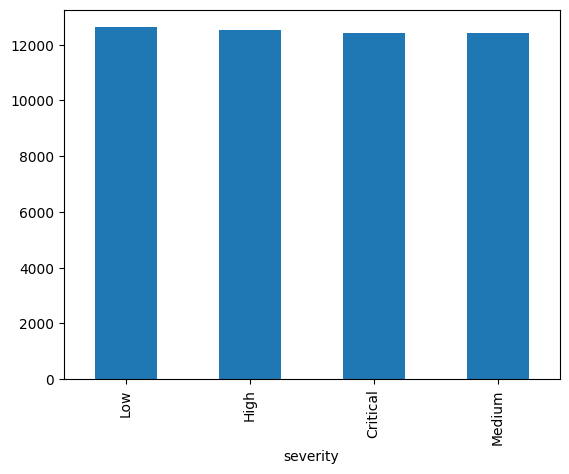

In [5]:
df["severity"].value_counts().plot(kind="bar")


## Text Preparation

> * We combine title, description, and explanation into one text field.


In [6]:
df["text"] = (
    df["title"].fillna("") + " " +
    df["description"].fillna("") + " " +
    df["explanation"].fillna("")
)


 ## Encode Severity Labels


In [7]:
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["severity"])

num_labels = df["label"].nunique()
print("Classes:", num_labels)


Classes: 4


## Train-Test Split


In [8]:
train_df, test_df = train_test_split(
    df[["text", "label"]],
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)


## Convert to HuggingFace Dataset


In [9]:
train_dataset = Dataset.from_pandas(train_df.reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df.reset_index(drop=True))


## Load BERT Model


In [10]:
MODEL_NAME = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Tokenization


In [11]:
def tokenize(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"]
)

test_dataset.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"]
)


Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

## Evaluation Metrics


In [12]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }


## Training Configuration


In [13]:
training_args = TrainingArguments(
    output_dir="./bug_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    save_total_limit=1,
    report_to="none",
    disable_tqdm=True
)


## Evaluation Metrics


In [14]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)

    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted")
    }


## Training Configuration


In [16]:
training_args = TrainingArguments(
    output_dir="./bug_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",
    save_total_limit=1,
    report_to="none",
    disable_tqdm=True
)


## Trainer Setup


In [17]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


/tmp/ipykernel_55/2147312783.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Model Training


In [18]:
trainer.train()


{'loss': 1.3893, 'grad_norm': 0.7196713089942932, 'learning_rate': 1.8669333333333334e-05, 'epoch': 0.2}
{'loss': 1.3877, 'grad_norm': 0.7898942232131958, 'learning_rate': 1.7336e-05, 'epoch': 0.4}
{'loss': 1.3889, 'grad_norm': 1.1363818645477295, 'learning_rate': 1.600266666666667e-05, 'epoch': 0.6}
{'loss': 1.3885, 'grad_norm': 0.6474498510360718, 'learning_rate': 1.4669333333333335e-05, 'epoch': 0.8}
{'loss': 1.3876, 'grad_norm': 0.43942147493362427, 'learning_rate': 1.3336e-05, 'epoch': 1.0}
{'eval_loss': 1.3866101503372192, 'eval_accuracy': 0.2507, 'eval_f1_weighted': 0.10050450147917167, 'eval_runtime': 36.0743, 'eval_samples_per_second': 277.205, 'eval_steps_per_second': 17.325, 'epoch': 1.0}
{'loss': 1.3872, 'grad_norm': 0.5900906324386597, 'learning_rate': 1.2002666666666668e-05, 'epoch': 1.2}
{'loss': 1.3872, 'grad_norm': 0.7663731575012207, 'learning_rate': 1.0669333333333333e-05, 'epoch': 1.4}
{'loss': 1.3869, 'grad_norm': 0.76378333568573, 'learning_rate': 9.336e-06, 'epoc

TrainOutput(global_step=7500, training_loss=1.3872835693359375, metrics={'train_runtime': 1561.9259, 'train_samples_per_second': 76.828, 'train_steps_per_second': 4.802, 'train_loss': 1.3872835693359375, 'epoch': 3.0})

## Model Evaluation


In [19]:
results = trainer.evaluate()
print(results)


{'eval_loss': 1.3865817785263062, 'eval_accuracy': 0.2534, 'eval_f1_weighted': 0.19989140467514704, 'eval_runtime': 36.4123, 'eval_samples_per_second': 274.633, 'eval_steps_per_second': 17.165, 'epoch': 3.0}
{'eval_loss': 1.3865817785263062, 'eval_accuracy': 0.2534, 'eval_f1_weighted': 0.19989140467514704, 'eval_runtime': 36.4123, 'eval_samples_per_second': 274.633, 'eval_steps_per_second': 17.165, 'epoch': 3.0}


## Save Model


In [20]:
trainer.save_model("final_bug_model")
tokenizer.save_pretrained("final_bug_model")


('final_bug_model/tokenizer_config.json',
 'final_bug_model/special_tokens_map.json',
 'final_bug_model/vocab.txt',
 'final_bug_model/added_tokens.json',
 'final_bug_model/tokenizer.json')

## Prediction Demo


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_severity(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True,
        max_length=256
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    pred = torch.argmax(outputs.logits, dim=1).cpu().item()
    return label_encoder.inverse_transform([pred])[0]

print(predict_severity("Server crashes after deployment"))


High
